# Проект

**Задача** - разработка стратегии взаимодействия с клиентами и прогноз вероятности оттока клиента (на уровне следующего месяца для каждого клиента) для сети фитнес-центров «Культурист-датасаентист» 

**данные** - набор данных, которые содержат данные на месяц до оттока и факт оттока на определённый месяц

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
# настройски визуализации
sns.set(rc={'figure.figsize':(10, 10)})


## Задание пользовательских функций

In [2]:
def get_hist(x, group_col, key_cols):
    # функция отрисовки гистограм с разделением по признакому group_col
    x_new = x.copy()
    x_new[key_cols] = df[key_cols]
    plt.title('Гистограммы признаков с разделением по факту оттока churn')
    for c in key_cols:
        for cl in x[group_col].unique():
            sns.distplot(x_new[x_new[group_col]==cl][c], 
                         label='{} = {}'.format(group_col, str(cl)), bins = 10, kde=False)
        plt.legend(['остался', 'ушел'], loc='upper center')
        plt.show()

### Загрузка и обзор данных

In [3]:
df = pd.read_csv('gym_churn.csv')

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В исходном датасете 14 столбцов и 4000 строк, из метода info() пропущенных значений не видно
В полях датасета представлена следующая информация:
1. **gender** - пол клиента, представлен в виде 0-1, формат int64
2. **Near_Location** - проживание или работа в районе, где находится фитнес-центр, представлен в виде 0-1, формат int64
3. **Partner** - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента), представлен в виде 0-1, формат int64
4. **Promo_friends** - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента), представлен в виде 0-1, формат int64
5. **Phone** -  наличие контактного телефона, представлен в виде 0-1, формат int64
6. **Contract_period** - длительность текущего действующего абонемента (месяц - 1, 6 месяцев - 6, год - 12), формат int64
7. **Group_visits** - факт посещения групповых занятий, представлен в виде 0-1, формат int64
8. **Age** - возраст клиента, формат int64
9. **Avg_additional_charges_total** - суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон, формат float64
10. **Month_to_end_contract** -  срок до окончания текущего действующего абонемента (в месяцах), формат float64
11. **Lifetime** - время с момента первого обращения в фитнес-центр (в месяцах), формат int64
12. **Avg_class_frequency_total** - средняя частота посещений в неделю за все время с начала действия абонемента, формат float64
13. **Avg_class_frequency_current_month** - средняя частота посещений в неделю за предыдущий месяц, формат float64
14. **Churn** - факт оттока в текущем месяце, представлен в виде 0-1, формат int64

1. Категориальные признаки - **gender, Near_Location, Partner, Promo_friend, Phone, Age, Contract_period, Group_visits, Month_to_end_contract ,Lifetime **
2. Количественные признаки - **Avg_additional_charges_total, Avg_class_frequency_total, Avg_class_frequency_current_month**

### Изменение названий полей

Приведем названия полей к стилю snake_case для большей читаемости и удобства работы

In [6]:
df.columns= df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Изменение типов данных

Изменим тип данных для поля **Month_to_end_contract** так как оно содержит только целые значения, приведем его к типу int

In [7]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')
df['month_to_end_contract'].unique()

array([ 5, 12,  1,  6,  3, 10, 11,  9,  4,  7,  8,  2], dtype=int64)

### Проверка на пропуски и дубликаты

In [8]:
print('Количество пропусков по столбцам:')
print( df.isna().sum())
print('Количество дубликатов в датасете равно', df.duplicated().sum())

Количество пропусков по столбцам:
gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64
Количество дубликатов в датасете равно 0


Пропуски и явные дубликаты в датасете отсутствуют

### Вывод
1. В исходном датасете 14 столбцов и 4000 строк
2. Названия полей датасета приведены к стилю snake_case для большей читаемости и удобства работы
3. Тип данных поля **Month_to_end_contract** был изменен на int64
4. Категориальные признаки - **gender, Near_Location, Partner, Promo_friend, Phone, Age, Contract_period, Group_visits, Month_to_end_contract ,Lifetime**
5. Количественные признаки - **Avg_additional_charges_total, Avg_class_frequency_total, Avg_class_frequency_current_month**

## Исследовательский анализ данных (EDA)

### Анализ статистичечких характеристик выборки

Посмотрим, есть ли в датасете отсутствующие признаки а также на средние значения и стандартные отклонения 


In [9]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


По средним значениям видно, что в нашем датасете примерно одинаковое количество обоих гендеров (среднее 0.51, стандартное 0.49), также примерно половина клиентов - сотрудники компаний партнеров клубов (среднее 0.48, стандартное 0.49). Большая часть клиентов живет в непосредственной близости от фитнес-залов (среднееn near_location	 0.84, маленькое стандартное отклонение - маленький разброс данных). Меньшая часть клиентов пришла по программе приведи друга (маленькое среднее 0.3). Номер телефона указан почти у всех. Также около половины клиентов посещает групповые занятия. 

Средний возраст клиентов 29 лет, стандартное отклонение +- 3 года (клиенты 27-32 года составляют большую часть выборки). Средний срок до окончания абонемента составляет около 4 с таким же стандартным отклонением. Лайфтайм клиентов имеет большой разброс и в среднем составляет 3.7. Среднее значения посещений классов в неделю - 1.8, но также есть выбросы - клиенты - которые занимаются и по 6 раз в неделю и вообще не занимаются за неделю. С помесячной ситуацией динамика аналогичная. 
Отскок клиентов составляет 0.26 что кажется не слишком большим значением.

### Анализ средних значений  по группам - отскочивших и оставшихся клиентов

In [10]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Исходя из анализа средних значений по группам:
- клиенты ухоят вне зависимости от пола
- больше ушедших клиентов живут не в близости от фитнес центра а также пришли не по программе приведи друга
- клиенты в отскоке берут абонементы на меньший срок и меньше посещают групповые занятия
- средний возраст отскачивших немного меьнше чем оставшихся
- отскочившие клиенты покупают меньше дополнительных услуг
- до момента отскока в среднем проходит месяц
- отскочившие клиенты посещали меньше занятий

Можно сделать вывод, что большинство отскочивших клиенты это те люди, которые решили попробовать для себя фитнес и взяли абонемент на месяц, и за этот месяц приняли решение о прекращении занятий 

### Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Построим попарные диаграммы рассеяния признак-целевая переменная для небинарных признаков

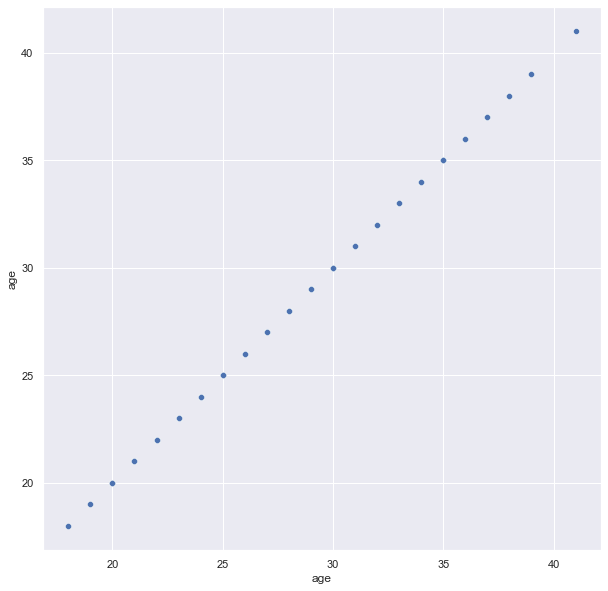

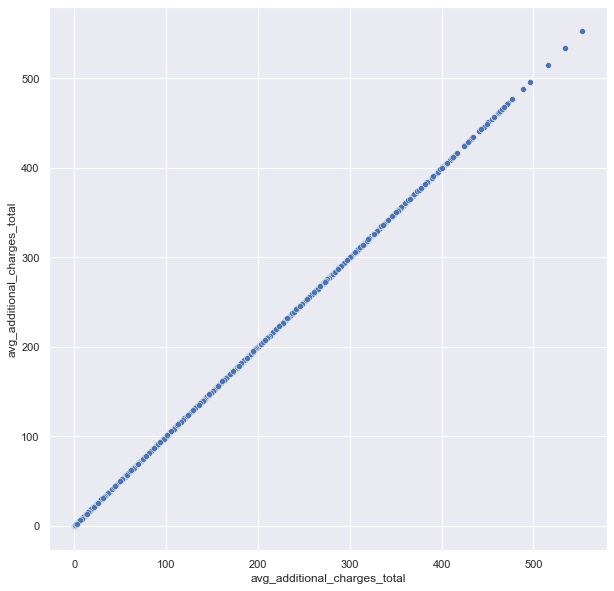

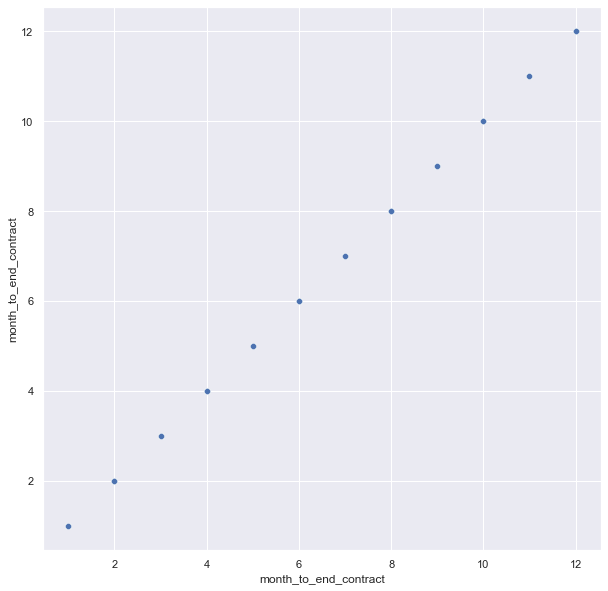

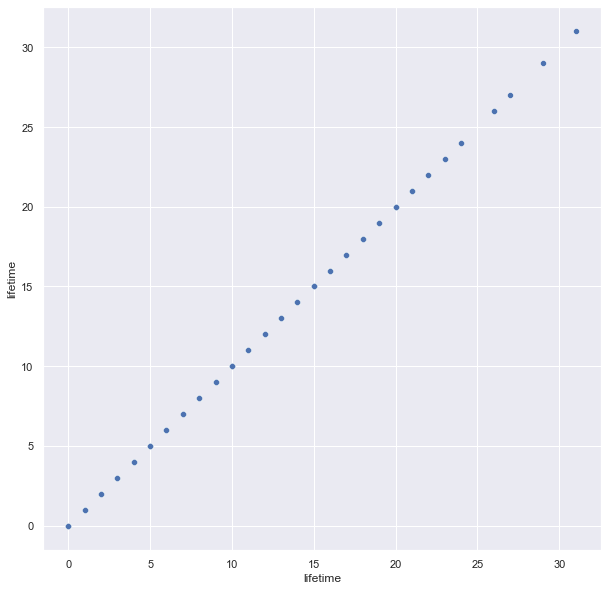

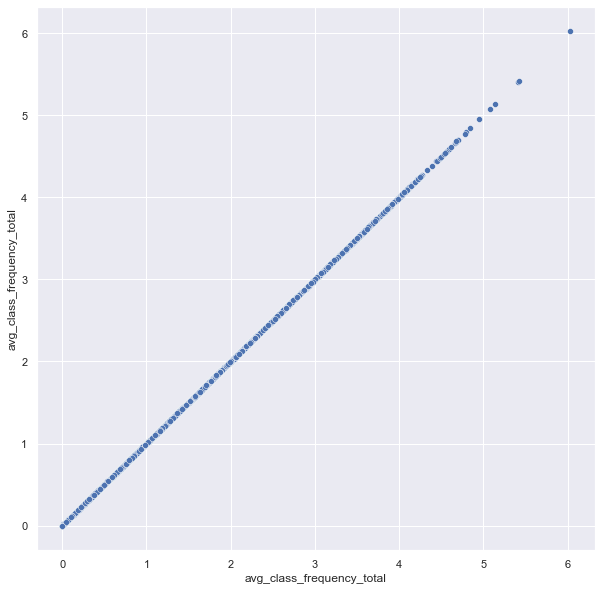

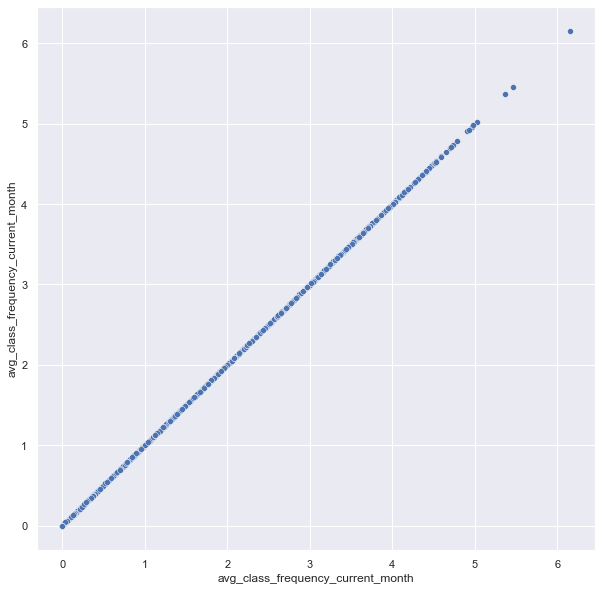

In [11]:
features = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 
            'avg_class_frequency_total', 'avg_class_frequency_current_month']
for col in features:
    sns.scatterplot(x=df[col], y=df[col])  #ваш код здесь
    plt.show()

По небинарным признакам на диаграммах не наблюдается выбросов и перекосов, что может говорить о хорошем качестве входных данных. 

Теперь посмотрим на гистограммы наших признаков с разделением по факту ухода. Для этого вызовем пользовательскую функциб **get_hist**

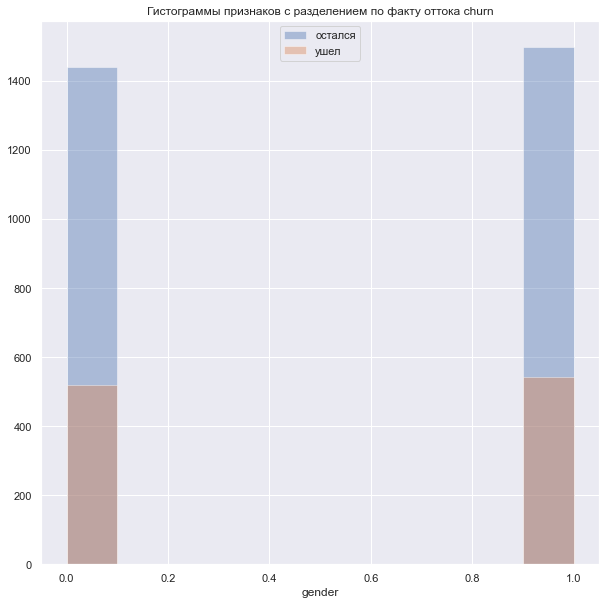

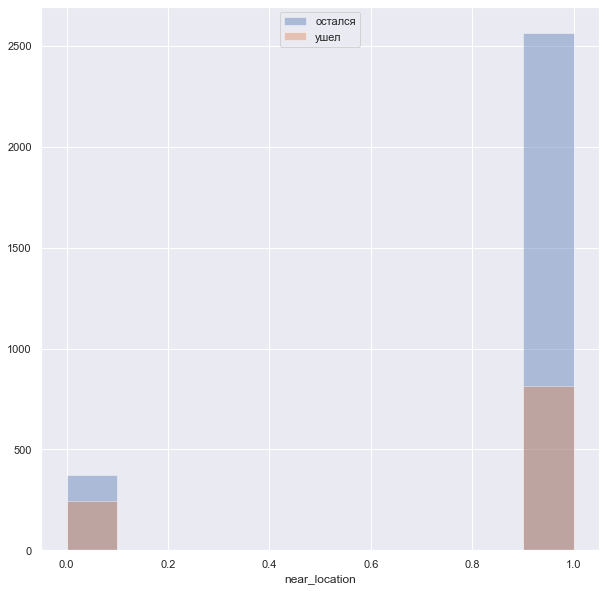

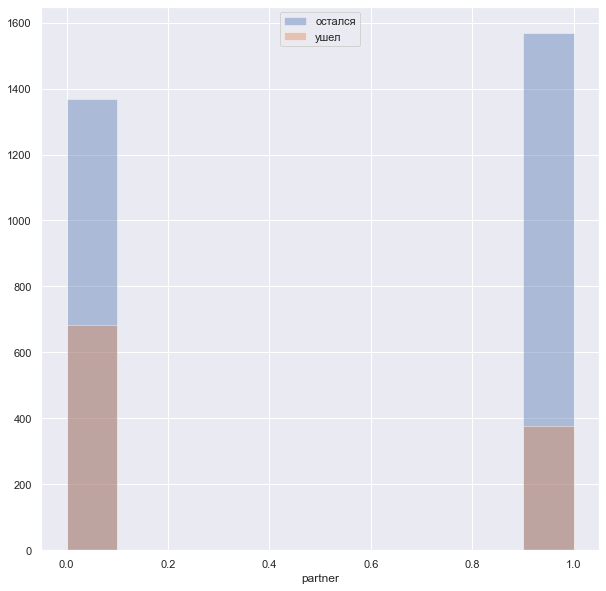

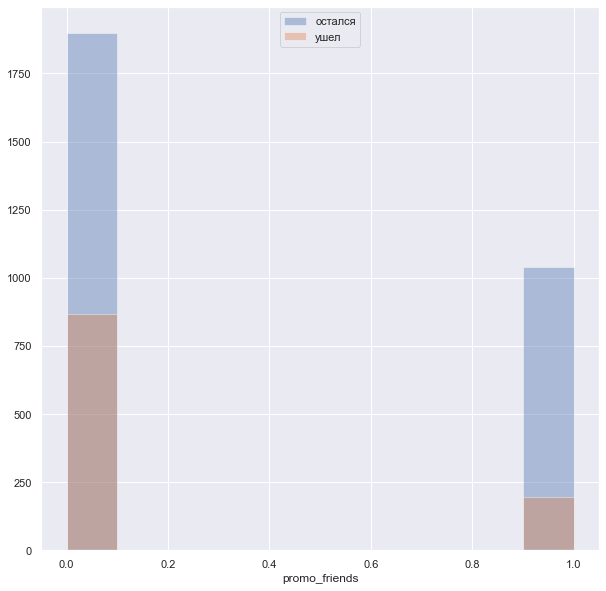

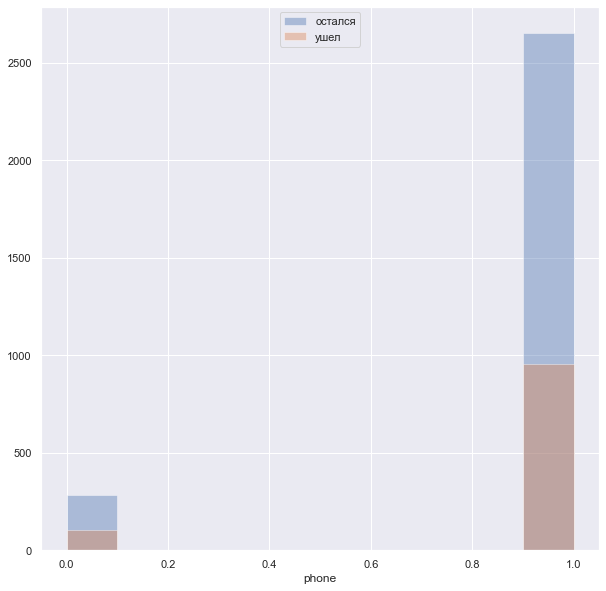

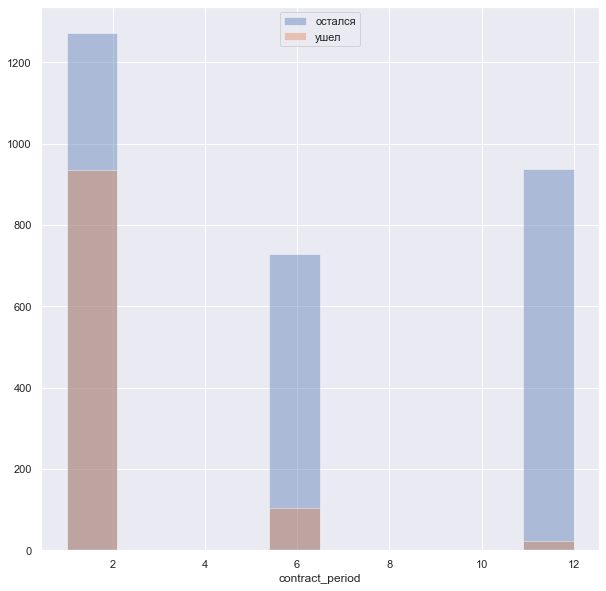

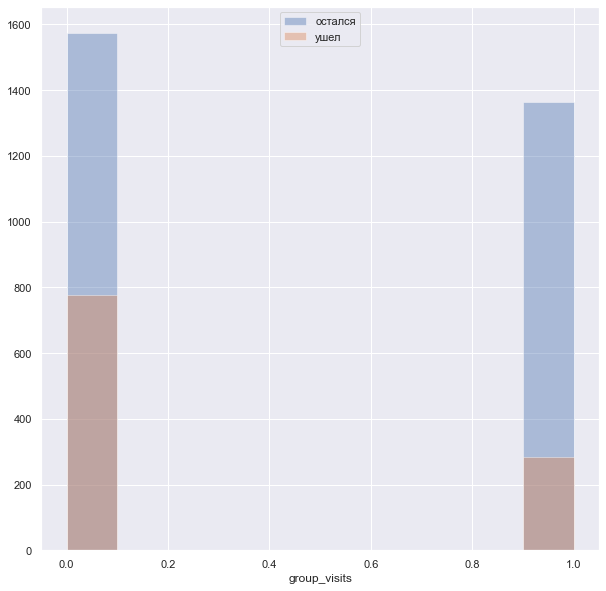

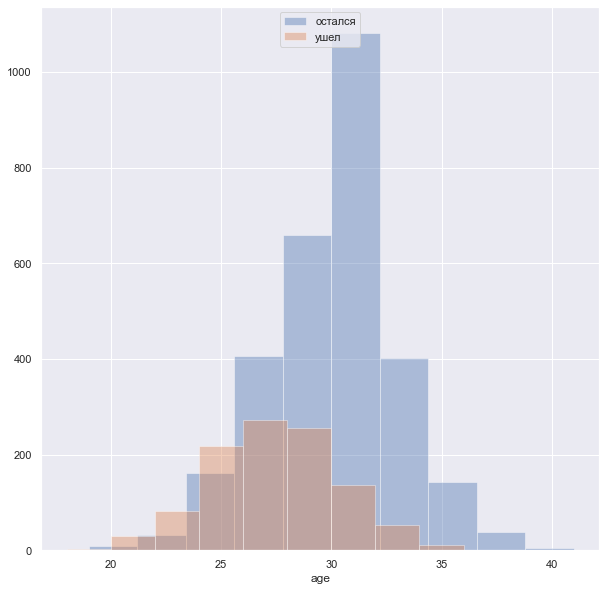

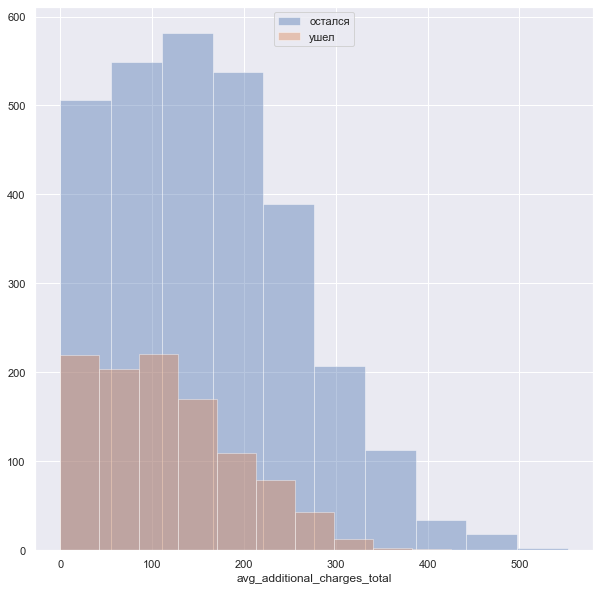

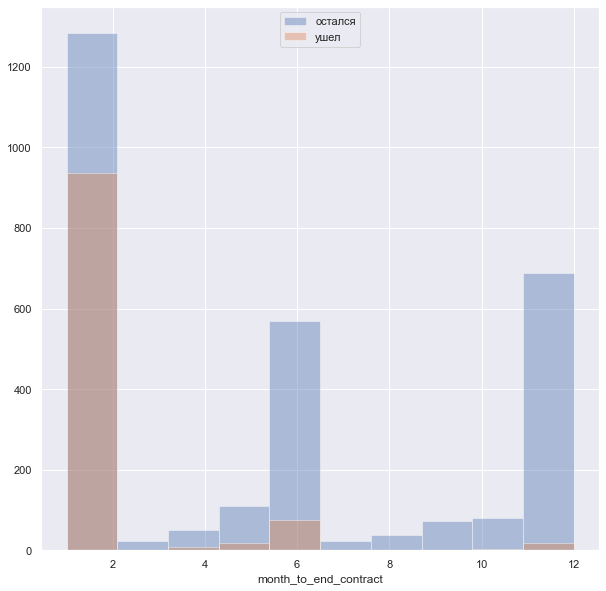

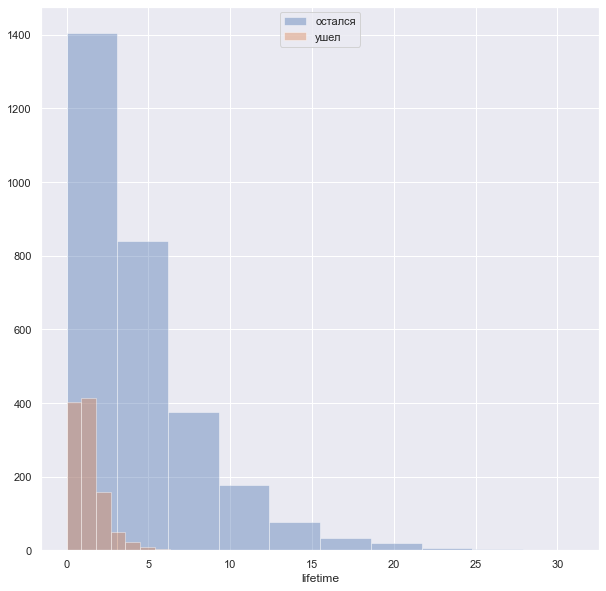

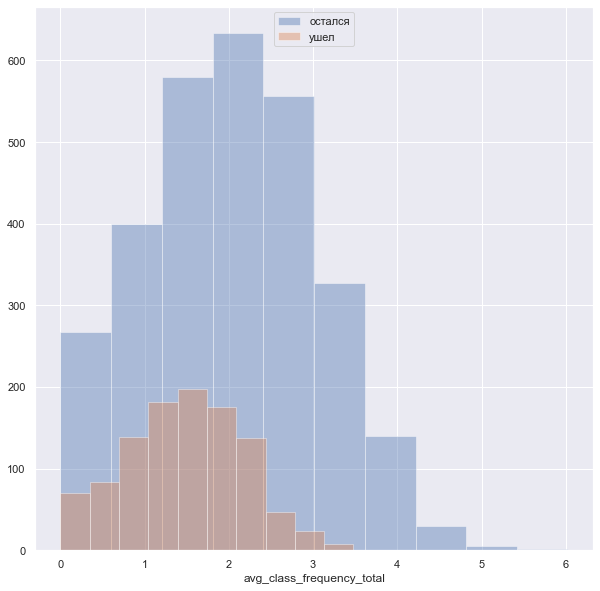

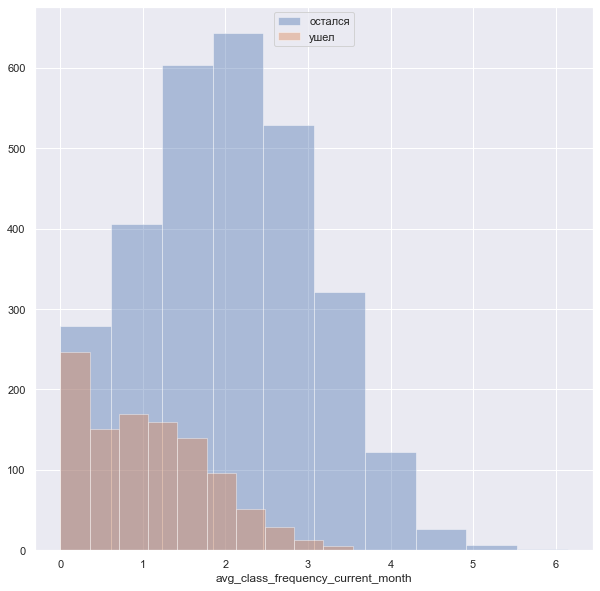

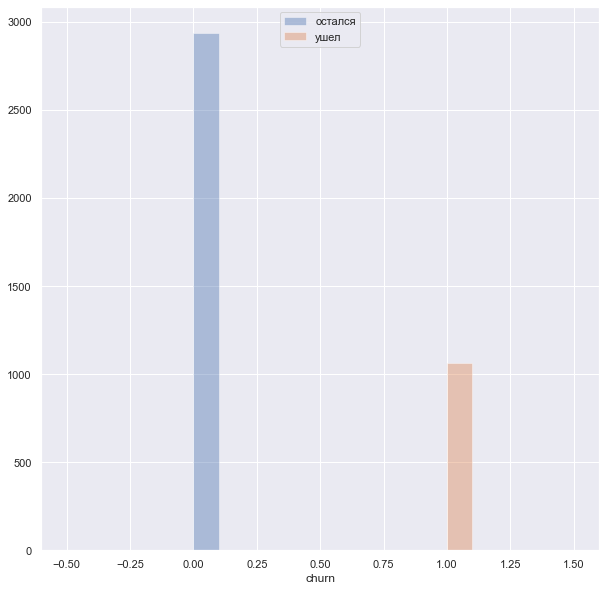

In [12]:
get_hist(df, 'churn', df.columns)

По гистограммам видно:
- отсутствие зависимости от пола 
- больше отскоков у клиентов, пришедших не от компаний партнеров
- больше отскоков без акции "приведи друга"
- значительно больше отскоков у тех, кто купил абонемент на месяц
- больше отскоков у тех, кто не ходил на групповые тренировки
- меньший возраст отскочивших
- ушедшие экономили на доп услугах сильнее
- у большинства ушедших оставалось меньше месяца до конца действия абонементов
- отсутствие оттока клиентов, которые с залом больше 5 месяцев
- спадающее среднее количество посещений занятий у отскочивших

### Построение матрицы корреляций

Оценим как коррелируют признаки друг с другом

<AxesSubplot:>

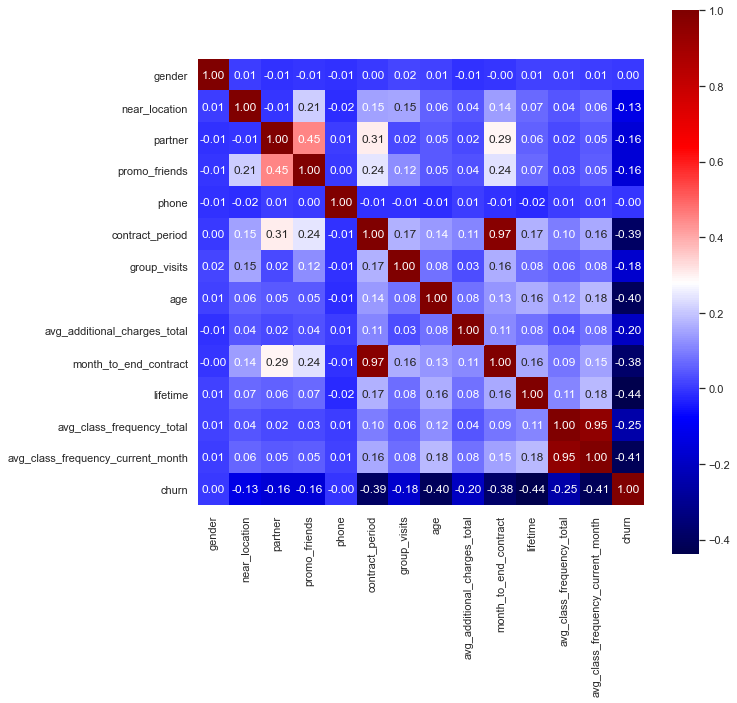

In [13]:
sns.set(rc = {'figure.figsize':(10,10)})  

sns.heatmap(df.corr(), annot=True, square=True, fmt = '0.2f',  cmap="seismic") 

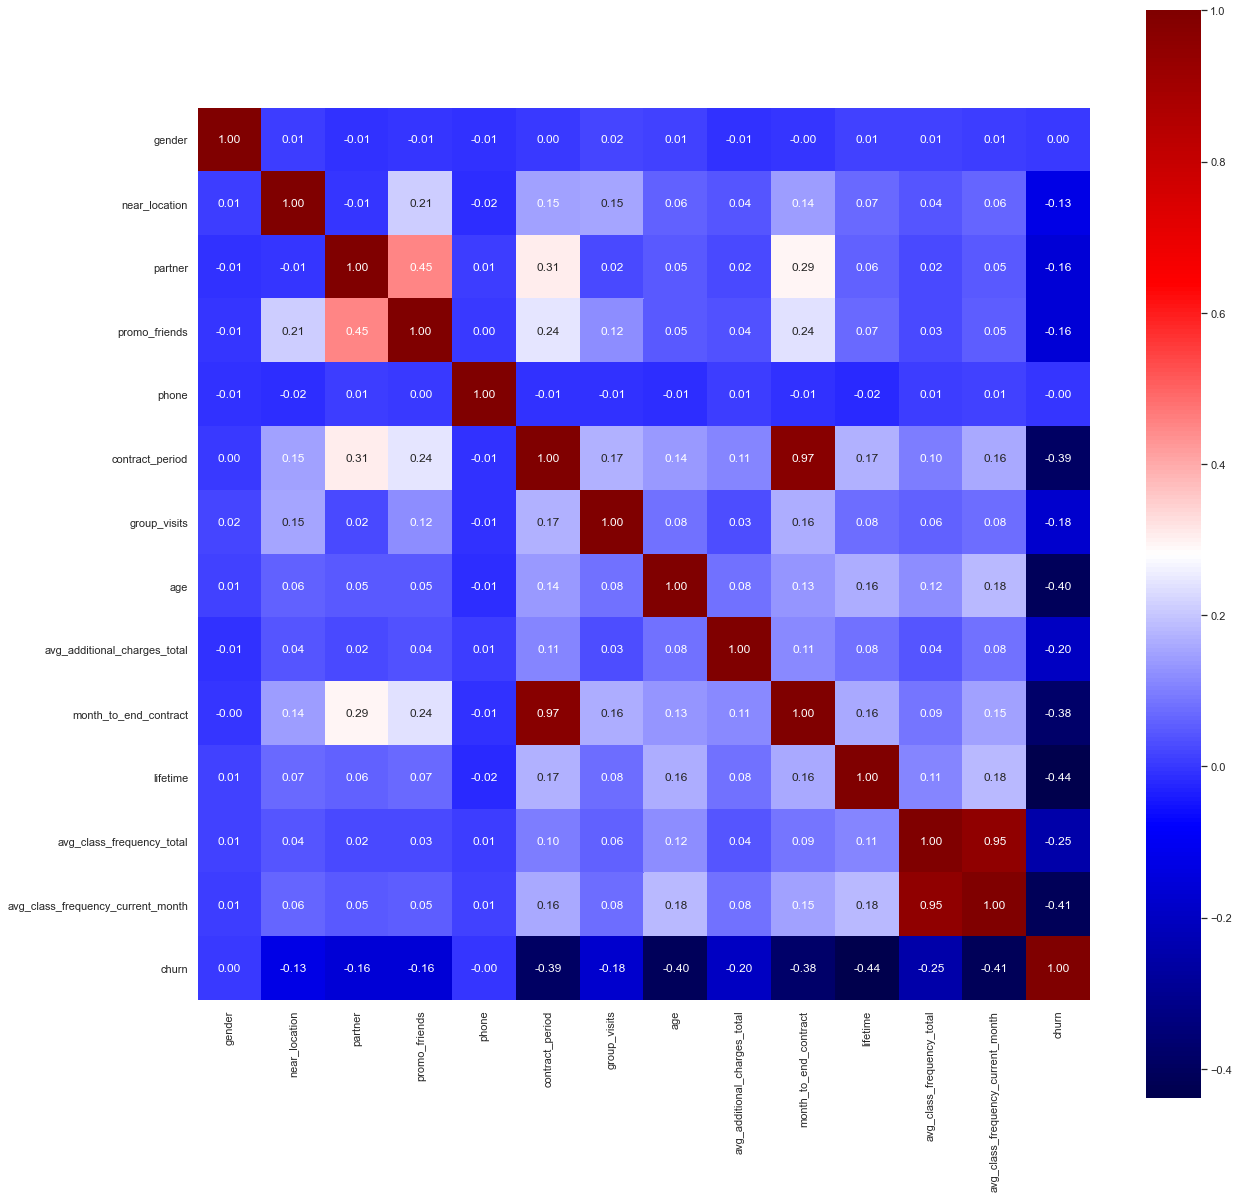

In [14]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df.corr(), annot=True, square=True, fmt = '0.2f',  cmap="seismic") 
plt.show()

avg_class_frequency_current_month, avg_class_frequency_total,  очень сильно коррелируют между собой. Также мультиколлинеарными признаками являются contract_period и month_to_end_contract. 
Наибольшая корреляция с churn у признаков lifetime(-0.44), avg_class_frequency_current_month(-0.41), age (0.40). 

### Вывод 

Из исследовательского анализа данных мы получили следующие выводы
1. Корреляция с возрастом клиентов (age), более молодые клиенты уходят чаще
2. Корреляция с средним посещением клиентов и временем с момента обращения (avg_class_frequency_current_month, lifetime)
3. Также важными признаками является: наличие приглашения друга (отток меньше с приглашениями), длительность текущего абонемента (в большинстве уходят клиенты с месячным абонементом), наличие корпоративных скидок (клиенты из компаний-партеров остаются больше), наличие зала поблизости. 
4. В целом уходящих клиентов можно описать как молодых людей, которые решили попробовать фитнес, взяли пробный абонемент на месяц, редко посещали групповые занятия и зал и приняли решение не продолжать


Построим модель бинарной классификации, где целевой признак — факт оттока клиента в следующем месяце. Сделаем это с помощью двух алгоритмов - логистическая регрессия и случайный лес. Поскольку это не алгоритмы линейной регрессии, то регуляризацию делать не требуется

Сначала разобьем наши данные на обучающую и валидационную выборки 

In [15]:
X = df.drop(['churn'], axis=1) 
y = df['churn'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)

X_train shape (3200, 13)
X_test shape (800, 13)
y_train shape (3200,)
y_test shape (800,)


Истандартизируем их

In [17]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Логистическая регрессия

Воспользуемся алгоритмом логистической регрессии - линейная модель для бинарной классификации

In [18]:
lr_model = LogisticRegression(random_state=0, solver='liblinear') 
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [19]:
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [20]:
print('Метрики логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_predictions)))

Метрики логистической регрессии
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84


### случайный лес

Обучим модель используя алгоритм random forest

In [21]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]


In [22]:
print('Метрики случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Метрики случайного леса
Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


### Вывод

1. Значения метрики доли правильных ответов accuracy одинаково для обеих моделей
2. Метрики точности Precision, полноты  Recall и меры F1 немного больше для модели логистической регрессии. 

## Кластеризация клиентов

### Дендрограмма

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков без целевого поля и нарисуем дендрограмму. 

In [23]:
# стандартизация для датафрейма без целевого столбца
X_sc = df.drop(['churn'], axis=1)
df_columns_list = X_sc.columns
X_sc = StandardScaler().fit_transform(X_sc)
X_sc = pd.DataFrame(X_sc, columns = df_columns_list).astype('float64')

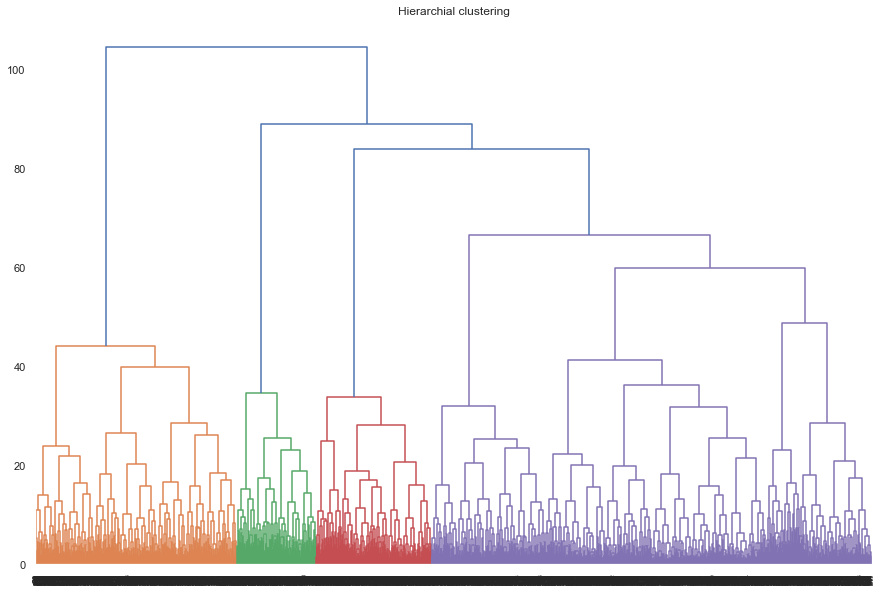

In [24]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

Выделено 4 кластера, в дальнейшем мы будем использовать 5, так как фиолетовый кластер теоретически можно интерпретировать за 2 + так сказано в условиях данного проекта. 

### Кластеризация на основе алгоритма K-means

Воспользуемся достаточно простым алгоритмом кластеризации K-means с числом классов равным 5

In [25]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

### Анализ среднего значения признаков по кластерам, распределения признаков по кластерам, доли оттока по кластерам

In [26]:
df['clusters'] = labels

In [27]:
df['clusters'].value_counts()

1    1067
4     936
2     831
3     781
0     385
Name: clusters, dtype: int64

In [28]:
df.groupby('clusters').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
clusters,,,,,,,,,,,,,,
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,0.480787,0.812559,0.000000,0.086223,1.000000,1.866917,0.325211,28.145267,131.369042,1.791003,2.345829,1.325865,1.086883,0.550141
2,0.559567,0.858002,0.338147,0.197353,0.998797,2.730445,0.448857,30.196149,164.579011,2.519856,5.010830,2.928140,2.934140,0.048135
3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172,0.395647
4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129,0.023504


Самый крупный кластер - 3, затем идет 0, затем 4, 2 ,1. 
- Среднее значение признака gender не меняется в зависимости от кластера
- Значение признака 	near_location почти единица для всех кластеров, кроме  2, аналогичная ситуация с признаком phone (он равен нулю лишь для кластера 1) - видно что некоторые признаки были в самом начале дендрограммы и по ним пошла ветка 
- Кластер 0 - люди с самыми длинными абонементами - так как признаки contract_period и month_to_end_contract имеют наибольшие  значения для этого кластера
- возраст почти не отличается для всех кластеров 
- наибольший отток у кластера 3 и 2 , наименьший у 0

Посмотрим на распределения

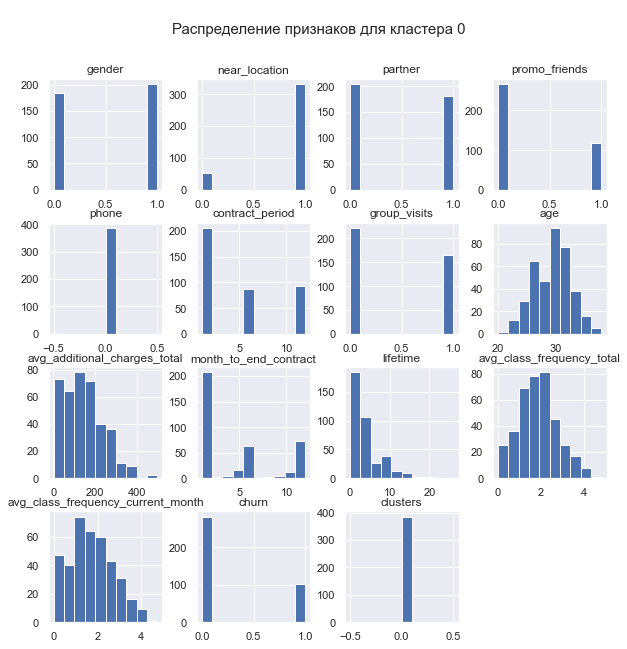

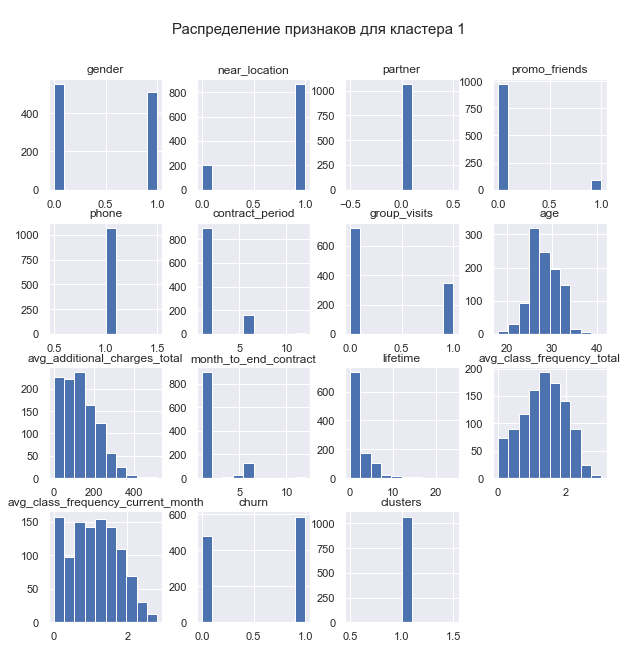

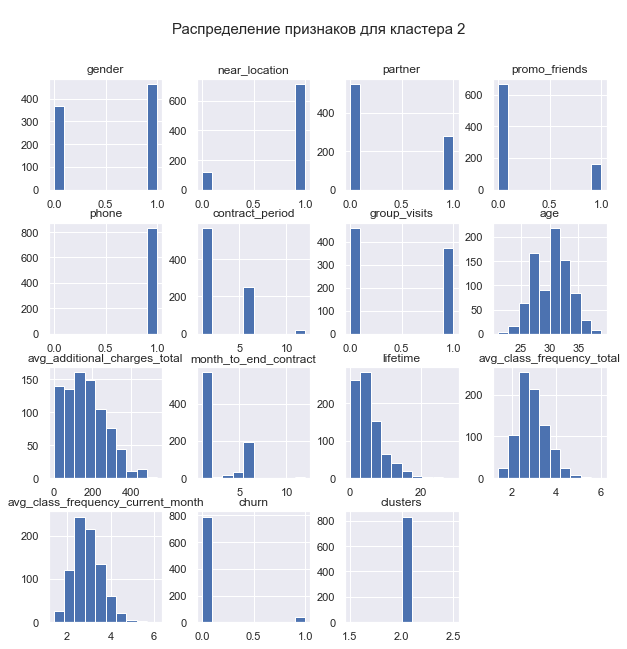

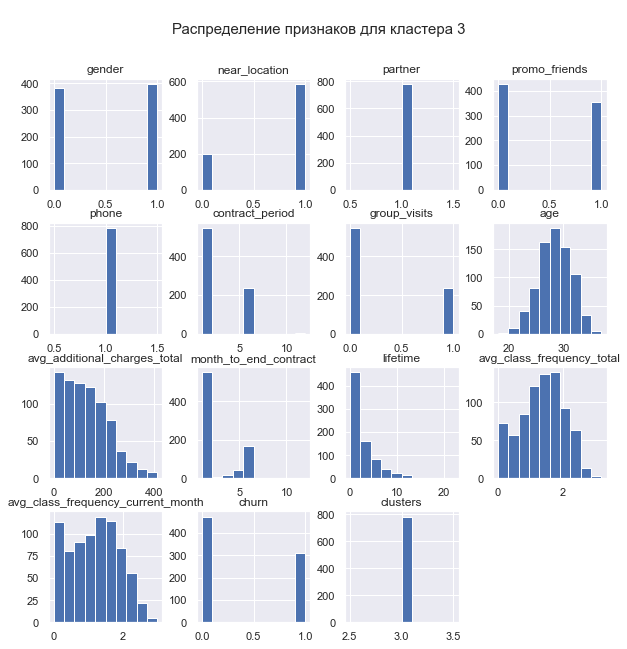

In [29]:
for cluster in range(0, 4):
    df[df['clusters']==cluster].hist(figsize=(10, 10))
    plt.suptitle('\nРаспределение признаков для кластера {}'.format(cluster), fontsize = 15)
    plt.show()

### Вывод

Из кластеризации мы получили следующие группы:
  1. Кластер 0
        - 1010 клиентов
        - фитнес вблизи от дома/работы
        - наивысший показатель прихода от компании - партнера 
        - наивысший показатель прихода по акции приведи друга
        - самые длинные абонементы 
        - наибольшее количества посещений групповых тренировок
        - возраст около 30
        - самый маленький показатель оттока 0.027
  2. Кластер 1
        - 385 клиентов
        - фитнес вблизи от дома/работы
        - отсутствие контактного номера 
        - возраст 29 лет
        - показатель оттока 0.0267
  3. Кластер 2 
        - 505 клиентов
        - фитнес вдали от дома/работы
        - не по акции приведи друга 
        - наименьшее количество посещений групповых занятий
        - возраст около 28.5
        - показатель оттока 0.443
  4. Кластер 3
        - 1262 клиента
        - фитнес вблизи от дома/работы
        - наименьшее количество приходов от компаний-партнеров
        - наименьшие абонементы по продолжительности (и соответственно лайфтайм) и наименьшая посещаемость тренировок
        - возраст около 28 лет
        - показатель оттока 0.514
  5. Кластер 4
        - 838 клиентов
        - фитнес вблизи от дома/работы
        - наименьшее количество приходов по акции приведи друга
        - возраст 30
        - наибольшая посещаемость занятий
        - показатель оттока 0.06
        
Таким образом, наибольшее количество пользователей уходят из кластера 3 и кластера 2 

## Общий вывод

1. В ходе предобработки названия полей датасета приведены к стилю snake_case, тип данных поля **Month_to_end_contract** был изменен на int64

2. Из исследовательского анализа данных мы получили следующие выводы
    1. Корреляция с возрастом клиентов (age), более молодые клиенты уходят чаще
    2. Корреляция с средним посещением клиентов и временем с момента обращения (avg_class_frequency_current_month, lifetime)
    3. Также важными признаками является: наличие приглашения друга (отток меньше с приглашениями), длительность текущего абонемента (в большинстве уходят клиенты с месячным абонементом), наличие корпоративных скидок (клиенты из компаний-партеров остаются больше), наличие зала поблизости. 
**В целом уходящих клиентов можно описать как молодых людей, которые решили попробовать фитнес, взяли пробный абонемент на месяц, редко посещали групповые занятия и зал и приняли решение не продолжать**

3. При сравнении алгоритмов логистической регрессии и случайного леса мы получили, что для данной задачи значения метрики доли правильных ответов accuracy одинаково для обеих моделей. Метрики точности Precision, полноты  Recall и меры F1 немного больше для модели логистической регрессии. 


4. Из кластеризации мы получили следующие группы:
  1. Кластер 0
        - 1010 клиентов
        - фитнес вблизи от дома/работы
        - наивысший показатель прихода от компании - партнера 
        - наивысший показатель прихода по акции приведи друга
        - самые длинные абонементы 
        - наибольшее количества посещений групповых тренировок
        - возраст около 30
        - самый маленький показатель оттока 0.027
  2. Кластер 1
        - 385 клиентов
        - фитнес вблизи от дома/работы
        - отсутствие контактного номера 
        - возраст 29 лет
        - показатель оттока 0.0267
  3. Кластер 2 
        - 505 клиентов
        - фитнес вдали от дома/работы
        - не по акции приведи друга 
        - наименьшее количество посещений групповых занятий
        - возраст около 28.5
        - показатель оттока 0.443
  4. Кластер 3
        - 1262 клиента
        - фитнес вблизи от дома/работы
        - наименьшее количество приходов от компаний-партнеров
        - наименьшие абонементы по продолжительности (и соответственно лайфтайм) и наименьшая посещаемость тренировок
        - возраст около 28 лет
        - показатель оттока 0.514
  5. Кластер 4
        - 838 клиентов
        - фитнес вблизи от дома/работы
        - наименьшее количество приходов по акции приведи друга
        - возраст 30
        - наибольшая посещаемость занятий
        - показатель оттока 0.068
        
Таким образом, наибольшее количество пользователей уходят из кластера 3 и кластера 2.


5. Касаемо рекомендаций, можно пробовать различные маркетинговые стратегии на разных группах. **Кластер 0** имеет наибольшие показатели прихода по совету друга или от компании, а также много ходит на групповые тренировки, при этом являются лояльными пользователями. Для них можно предложить более углубленные программы и участие во внутренних мероприятиях, дабы еще сильнее повысить их лояльность. **Кластер 4** - клиенты посещающие фитнес больше всех - нацелены на какой-то результат, скидки на персональные тренировки и составные программы питания могут быть полезны. **Кластер 3** - самый большой показатель оттока, можно устроить пользовательский опрос с целью понять причины отваливания и работать с наиболее встречающимися. Также предложения бесплатных групповых занятий раз в какое-то время или каких-то опций, уникальных конкретно для этого зала, может помочь уменьшить долю оттокаю
